<a href="https://colab.research.google.com/github/CSSamarasinghe/SE4050_Assignment/blob/IT21263194/Change3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt


In [8]:
# Load the IMDB dataset with num_words=10000
num_words = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)

# Set a maximum length for reviews (e.g., 200 words)
maxlen = 200

# Pad sequences so that they all have the same length
X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

# Display the shape of training and testing data
print(f"Training entries: {len(X_train)}, labels: {len(y_train)}")
print(f"Test entries: {len(X_test)}, labels: {len(y_test)}")


Training entries: 25000, labels: 25000
Test entries: 25000, labels: 25000


In [9]:
# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.long)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [10]:
from torch.utils.data import TensorDataset, DataLoader

# Create TensorDataset objects
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)

# Create DataLoader objects
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size)


In [11]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, output_size, n_layers, dropout):
        super(SentimentLSTM, self).__init__()

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_size)

        # LSTM layer
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers=n_layers, batch_first=True)

        # Dropout layer
        self.dropout = nn.Dropout(dropout)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

        # Sigmoid activation function
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Pass input through embedding layer
        embeds = self.embedding(x)

        # Pass embeddings through LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(embeds)

        # Apply dropout to the output of the last LSTM cell
        out = self.dropout(lstm_out[:, -1, :])

        # Pass through fully connected layer
        out = self.fc(out)

        # Apply sigmoid activation
        return self.sigmoid(out)


In [12]:
# Model hyperparameters
vocab_size = num_words  # Since num_words=10000
embed_size = 128
hidden_size = 128
output_size = 1  # Binary classification
n_layers = 2
dropout = 0.5

# Instantiate the model
model = SentimentLSTM(vocab_size, embed_size, hidden_size, output_size, n_layers, dropout)


In [13]:
# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [14]:
# Training loop
num_epochs = 5
train_losses = []
model.train()  # Set the model to training mode

for epoch in range(num_epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()  # Clear gradients

        # Forward pass
        outputs = model(X_batch).squeeze(1)

        # Compute loss
        loss = criterion(outputs, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/5], Loss: 0.5901
Epoch [2/5], Loss: 0.4840
Epoch [3/5], Loss: 0.3662
Epoch [4/5], Loss: 0.3046
Epoch [5/5], Loss: 0.2586


In [15]:
# Evaluation on test data
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch).squeeze(1)
        predicted = (outputs > 0.5).float()
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.8562


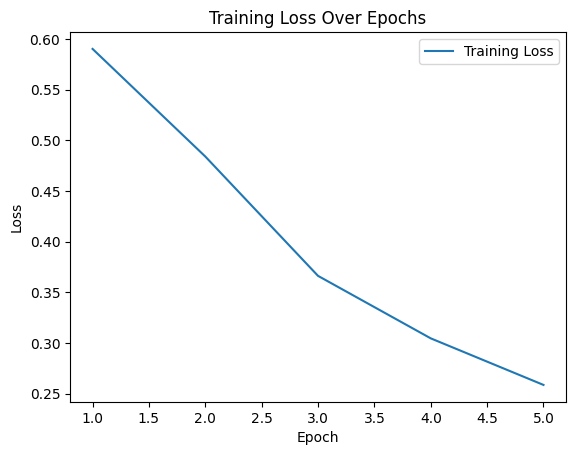

In [16]:
# Plot training loss over epochs
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
